<a href="https://colab.research.google.com/github/sravan1320/NMT/blob/main/fine_tune_hugging_face_translation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### If you dont want to use Wandb, disable Wandb otherwise optional

references for WANDB
https://analyticsindiamag.com/hands-on-guide-to-weights-and-biases-wandb-with-python-implementation/

https://docs.wandb.ai/


In [1]:
import os
os.environ["WANDB_DISABLED"]="true"

# Install required packages

In [1]:
! pip install datasets transformers sacrebleu torch sentencepiece transformers[sentencepiece]

     |████████████████████████████████| 270 kB 7.9 MB/s 
     |████████████████████████████████| 2.9 MB 46.5 MB/s 
     |████████████████████████████████| 90 kB 9.6 MB/s 
     |████████████████████████████████| 1.2 MB 62.9 MB/s 
     |████████████████████████████████| 123 kB 72.2 MB/s 
     |████████████████████████████████| 1.3 MB 57.3 MB/s 
     |████████████████████████████████| 243 kB 44.2 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 3.3 MB 43.8 MB/s 
     |████████████████████████████████| 895 kB 71.2 MB/s 
     |████████████████████████████████| 636 kB 37.2 MB/s 
     |████████████████████████████████| 142 kB 57.8 MB/s 
     |████████████████████████████████| 294 kB 66.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Make sure your version of Transformers is at least 4.11.0 since the functionality was introduced in that version

In [29]:
import transformers
print(transformers.__version__)

4.11.1


# Fine-tuning a model on a translation task

In this notebook, we will see how to fine-tune one of the hugging-face Transformers model for a english to romanian translation task. We will use the WMT dataset, a machine translation dataset composed from a collection of various sources, including news commentaries and parliament proceedings.

Below is the example translation text using pre-trained model

Reference : https://huggingface.co/Helsinki-NLP/opus-mt-en-ro


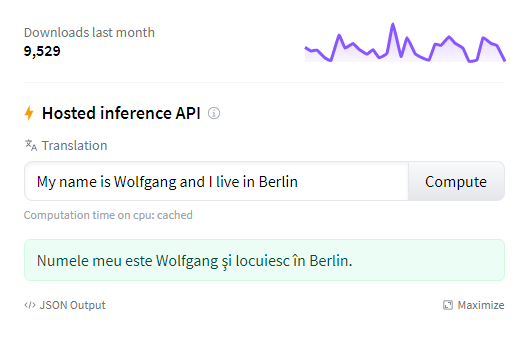

We will see how to easily load the dataset for this task using Datasets and how to fine-tune a model on it using the Trainer API

This notebook is built to run with any model checkpoint from the Model Hub as long as that model has a sequence-to-sequence version in the Transformers library. Here we picked the Helsinki-NLP/opus-mt-en-ro checkpoint.
**[You may not download the model when you working in private cloud, we can download model from Files and versions tab.]**

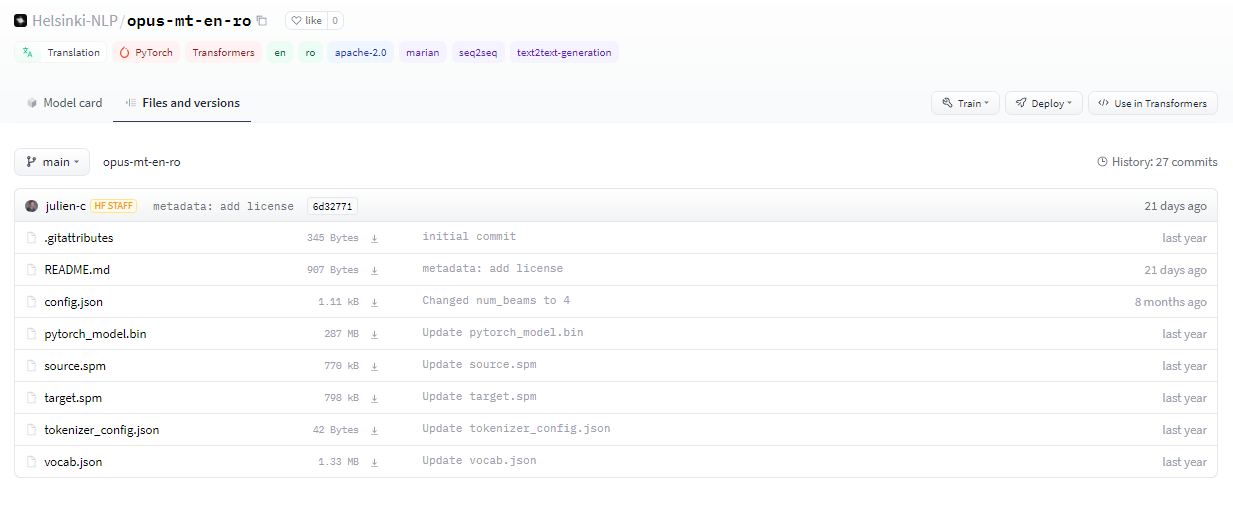



In [5]:
model_checkpoint = "Helsinki-NLP/opus-mt-en-ro"

### Loading the dataset

We will use the [datasets](https://github.com/huggingface/datasets/tree/master/datasets/wmt16) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions load_dataset and load_metric. We use the English/Romanian part of the WMT dataset here

In [6]:
from datasets import load_dataset, load_metric
raw_datasets = load_dataset("wmt16", "ro-en")
metric = load_metric("sacrebleu")

Reusing dataset wmt16 (/root/.cache/huggingface/datasets/wmt16/ro-en/1.0.0/0d9fb3e814712c785176ad8cdb9f465fbe6479000ee6546725db30ad8a8b5f8a)


  0%|          | 0/3 [00:00<?, ?it/s]

The dataset object itself is [datasetdict](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set:

In [7]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 610320
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 1999
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 1999
    })
})

In [8]:
raw_datasets["train"][0]

{'translation': {'en': 'Membership of Parliament: see Minutes',
  'ro': 'Componenţa Parlamentului: a se vedea procesul-verbal'}}

To get a sense of how the data looks like, the following function will show some examples picked randomly in the dataset.

In [9]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML
def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))
show_random_elements(raw_datasets["train"])

,translation
0,"{'en': 'Unfortunately, the agreement signed at the end of last week between Gazprom and the State Oil Company of Azerbaijan may jeopardise the Nabucco project.', 'ro': 'Din păcate, înţelegerea încheiată la sfârşitul săptămânii trecute între Gazprom şi Compania Petrolieră de Stat din Azerbaidjan poate pune în pericol proiectul Nabuco.'}"
1,"{'en': 'We want to have five years instead of seven and an adjustment to the period so that the new Parliament and a new Commission can have real influence over the framework that is to apply during their term of office.', 'ro': 'Dorim să avem cinci ani în loc de şapte şi o ajustare la perioadă, astfel încât noul Parlament şi o nouă Comisie să poată avea o influenţă reală asupra cadrului care se aplică pe durata mandatului acestora.'}"
2,"{'en': 'Religious rights are an integral part of this policy and that is why we are in favour of strengthening them.', 'ro': 'Drepturile religioase fac parte integrantă din această politică şi, de aceea, suntem în favoarea consolidării acestora.'}"
3,"{'en': 'Of course, a huge emphasis, as I would expect, was placed on human rights - the importance of making sure that is clearly part of all the dynamic relationships that we have and encompasses our work.', 'ro': 'Bineînţeles că drepturile omului au beneficiat, astfel cum mă aşteptam, de o atenţie specială - importanţa de a garanta respectarea acestora este, în mod clar, inclusă în toate relaţiile dinamice pe care le avem şi cuprinde munca noastră.'}"
4,"{'en': 'Consider, for instance, the growing need for energy and basic commodities in Asia, with China and India as the prime consumers, the unsolved geopolitical crises in various parts of the world (in the Middle East in particular), nuclear proliferation, and the visible and hidden aspects of the struggle against terrorism.', 'ro': 'Să ne gândim, spre exemplu, la nevoia crescândă de energie şi bunuri de bază în Asia, cu China şi India în rol de consumatori principali, crizele nerezolvate în diverse părţi ale lumii (în special în Orientul Mijlociu), proliferarea armelor nucleare şi aspectele vizibile şi ascunse ale luptei împotriva terorismului.'}"


In [10]:
metric

Metric(name: "sacrebleu", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='sequence'), length=-1, id='references')}, usage: """
Produces BLEU scores along with its sufficient statistics
from a source against one or more references.

Args:
    predictions: The system stream (a sequence of segments).
    references: A list of one or more reference streams (each a sequence of segments).
    smooth_method: The smoothing method to use. (Default: 'exp').
    smooth_value: The smoothing value. Only valid for 'floor' and 'add-k'. (Defaults: floor: 0.1, add-k: 1).
    tokenize: Tokenization method to use for BLEU. If not provided, defaults to 'zh' for Chinese, 'ja-mecab' for
        Japanese and '13a' (mteval) otherwise.
    lowercase: Lowercase the data. If True, enables case-insensitivity. (Default: False).
    force: Insist that your tokenized input is actually detokenized.

Returns:
    'score': BLEU score,
    'counts'

You can call its compute method with your predictions and labels, which need to be list of decoded strings (list of list for the labels):

In [11]:
fake_preds = ["hello there", "general kenobi"]
fake_labels = [["hello there"], ["general kenobi"]]
metric.compute(predictions=fake_preds, references=fake_labels)

{'bp': 1.0,
 'counts': [4, 2, 0, 0],
 'precisions': [100.0, 100.0, 0.0, 0.0],
 'ref_len': 4,
 'score': 0.0,
 'sys_len': 4,
 'totals': [4, 2, 0, 0]}

# Preprocessing the data

Before we can feed those texts to our model, we need to preprocess them. This is done by a Transformers Tokenizer which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the AutoTokenizer.from_pretrained method, which will ensure:

we get a tokenizer that corresponds to the model architecture we want to use,
we download the vocabulary used when pretraining this specific checkpoint.
That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

If you downloaded the model manually, you can provide model present directory instead of model_checkpoint

In [12]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/770k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33M [00:00<?, ?B/s]

You can directly call this tokenizer on one sentence or a pair of sentences:

In [13]:
tokenizer(["Hello, this one sentence!", "This is another sentence."])

{'input_ids': [[125, 778, 3, 63, 141, 9191, 23, 0], [187, 32, 716, 9191, 2, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}

To prepare the targets for our model, we need to tokenize them inside the as_target_tokenizer context manager. This will make sure the tokenizer uses the special tokens corresponding to the targets:

In [14]:
with tokenizer.as_target_tokenizer():
    print(tokenizer(["Hello, this one sentence!", "This is another sentence."]))

{'input_ids': [[10334, 1204, 3, 15, 8915, 27, 452, 59, 29579, 581, 23, 0], [235, 1705, 11, 32, 8, 1205, 5305, 59, 29579, 581, 2, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


We can then write the function that will preprocess our samples. We just feed them to the tokenizer with the argument truncation=True. This will ensure that an input longer that what the model selected can handle will be truncated to the maximum length accepted by the model. The padding will be dealt with later on (in a data collator) so we pad examples to the longest length in the batch and not the whole dataset.

In [15]:
prefix = ""
max_input_length = 128
max_target_length = 128
source_lang = "en"
target_lang = "ro"
def preprocess_function(examples):
    inputs = [prefix + ex[source_lang] for ex in examples["translation"]]
    targets = [ex[target_lang] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)
    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [16]:
preprocess_function(raw_datasets['train'][:2])

{'input_ids': [[393, 4462, 14, 1137, 53, 216, 28636, 0], [24385, 14, 28636, 14, 4646, 4622, 53, 216, 28636, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[42140, 494, 1750, 53, 8, 59, 903, 3543, 9, 15202, 0], [36199, 6612, 9, 15202, 122, 568, 35788, 21549, 53, 8, 59, 903, 3543, 9, 15202, 0]]}

To apply this function on all the pairs of sentences in our dataset, we just use the map method of our dataset object we created earlier. This will apply the function on all the elements of all the splits in dataset, so our training, validation and testing data will be preprocessed in one single command

In [17]:
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

  0%|          | 0/611 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

## Fine-tuning the model

Now that our data is ready, we can download the pretrained model and fine-tune it. Since our task is of the sequence-to-sequence kind, we use the AutoModelForSeq2SeqLM class. Like with the tokenizer, the from_pretrained method will download and cache the model for us.

In [18]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/287M [00:00<?, ?B/s]

To instantiate a Seq2SeqTrainer, we will need to define three more things. The most important is the [Seq2SeqTrainingArguments](https://huggingface.co/transformers/main_classes/trainer.html#transformers.Seq2SeqTrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [19]:
batch_size = 16
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-{source_lang}-to-{target_lang}",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True    
)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the batch_size defined at the top of the cell and customize the weight decay. Since the Seq2SeqTrainer will save the model regularly and our dataset is quite large, we tell it to make three saves maximum. Lastly, we use the predict_with_generate option (to properly generate summaries) and activate mixed precision training (to go a bit faster).

Model will save under **{model_name}-finetuned-{source_lang}-to-{target_lang}** directory

Then, we need a special kind of data collator, which will not only pad the inputs to the maximum length in the batch, but also the labels:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [20]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

The last thing to define for our Seq2SeqTrainer is how to compute the metrics from the predictions. We need to define a function for this, which will just use the metric we loaded earlier, and we have to do a bit of pre-processing to decode the predictions into texts:

In [21]:
import numpy as np
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]
    return preds, labels
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

Then we just need to pass all of this along with our datasets to the Seq2SeqTrainer:

In [22]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

We can now finetune our model by just calling the train method:

In [23]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `MarianMTModel.forward` and have been ignored: translation.
***** Running training *****
  Num examples = 610320
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 38145


Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,0.743500,1.288051,28.079200,34.064500


Saving model checkpoint to opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500
Configuration saved in opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500/config.json
Model weights saved in opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500/pytorch_model.bin
tokenizer config file saved in opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500/tokenizer_config.json
Special tokens file saved in opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500/special_tokens_map.json
Saving model checkpoint to opus-mt-en-ro-finetuned-en-to-ro/checkpoint-1000
Configuration saved in opus-mt-en-ro-finetuned-en-to-ro/checkpoint-1000/config.json
Model weights saved in opus-mt-en-ro-finetuned-en-to-ro/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in opus-mt-en-ro-finetuned-en-to-ro/checkpoint-1000/tokenizer_config.json
Special tokens file saved in opus-mt-en-ro-finetuned-en-to-ro/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to opus-mt-en-ro-finetuned-en-to-ro/checkpoint-1500
Configuration saved i

TrainOutput(global_step=38145, training_loss=0.7718851005223182, metrics={'train_runtime': 16762.4704, 'train_samples_per_second': 36.41, 'train_steps_per_second': 2.276, 'total_flos': 2.128216892689613e+16, 'train_loss': 0.7718851005223182, 'epoch': 1.0})

In [24]:
import os
for dirname, _, filenames in os.walk('opus-mt-en-ro-finetuned-en-to-ro'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

opus-mt-en-ro-finetuned-en-to-ro/checkpoint-37000/vocab.json
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-37000/rng_state.pth
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-37000/config.json
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-37000/tokenizer_config.json
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-37000/trainer_state.json
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-37000/scheduler.pt
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-37000/special_tokens_map.json
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-37000/pytorch_model.bin
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-37000/target.spm
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-37000/source.spm
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-37000/training_args.bin
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-37000/optimizer.pt
opus-mt-en-ro-finetuned-en-to-ro/runs/Sep30_03-49-58_a84265f68a25/events.out.tfevents.1632973810.a84265f68a25.217.0
opus-mt-en-ro-finetuned-en-to-ro/runs/Sep30_03-49-58_a84265f68a25/1632973810.56194/events.out.tfev

Our fine tuned model already saved under *opus-mt-en-ro-finetuned-en-to-ro/checkpoint-38000*

Load the model and translate some text from english to romanian

In [30]:
from transformers import MarianMTModel, MarianTokenizer
src_text = ['My name is Sarah and I live in London']

model_name = 'opus-mt-en-ro-finetuned-en-to-ro/checkpoint-38000'
tokenizer = MarianTokenizer.from_pretrained(model_name)
print(tokenizer.supported_language_codes)


Didn't find file opus-mt-en-ro-finetuned-en-to-ro/checkpoint-38000/added_tokens.json. We won't load it.
Didn't find file opus-mt-en-ro-finetuned-en-to-ro/checkpoint-38000/tokenizer.json. We won't load it.
loading file opus-mt-en-ro-finetuned-en-to-ro/checkpoint-38000/source.spm
loading file opus-mt-en-ro-finetuned-en-to-ro/checkpoint-38000/target.spm
loading file opus-mt-en-ro-finetuned-en-to-ro/checkpoint-38000/vocab.json
loading file opus-mt-en-ro-finetuned-en-to-ro/checkpoint-38000/tokenizer_config.json
loading file None
loading file opus-mt-en-ro-finetuned-en-to-ro/checkpoint-38000/special_tokens_map.json
loading file None


[]


In [31]:
model = MarianMTModel.from_pretrained(model_name)
translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True))
[tokenizer.decode(t, skip_special_tokens=True) for t in translated]

loading configuration file opus-mt-en-ro-finetuned-en-to-ro/checkpoint-38000/config.json
Model config MarianConfig {
  "_name_or_path": "Helsinki-NLP/opus-mt-en-ro",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "swish",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "MarianMTModel"
  ],
  "attention_dropout": 0.0,
  "bad_words_ids": [
    [
      59542
    ]
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 512,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 59542,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    

['Numele meu este Sarah şi locuiesc la Londra']

our fine tune model is doing far better than pre-trained model and close to google translator

**input text** -> My name is Sarah and I live in London

**pre-trained model prediction** -> Numele meu este Sarah şi locuiesc în Londra.

**fine-tune model prediction** -> Numele meu este Sarah şi locuiesc la Londra

**google translator prediction** -> Numele meu este Sarah şi locuiesc la Londra


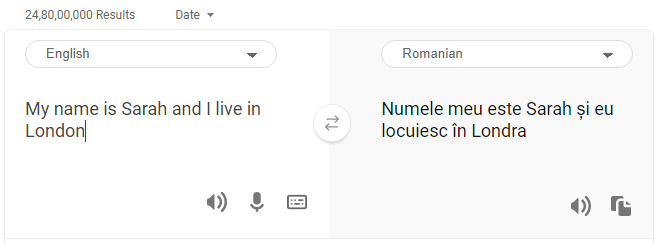

